**Sumber Dataset :** https://www.kaggle.com/joaoholz/brazil-weather-climate-data?select=dataset_0.csv

#Import Library yang digunakan

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Pembuatan Callback
Jika mae dibawah 0.9 akan menghentikan proses fitting


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('mae') <= 0.9 or logs.get('val_mae') <= 0.9) :
            print('\nReached 90 % accuracy so cancelling training!')
            self.model.stop_training = True

callbacks = myCallback()

# *Reading Data and Cleaning Data*

In [3]:
df = pd.read_csv('dataset1.csv', nrows=10000)

In [4]:
df = df.drop(columns=['Unnamed: 2'])
df = df.rename(columns={'A612 - temperatura maxima na hora ant. (aut) (°c)': 'temp'})

In [5]:
df

,date_time,temp
0,11/4/2006 1:00,23.9
1,11/4/2006 2:00,23.6
2,11/4/2006 3:00,23.6
3,11/4/2006 4:00,23.7
4,11/4/2006 5:00,23.6
...,...,...
9995,12/25/2007 12:00,28.5
9996,12/25/2007 13:00,28.6
9997,12/25/2007 14:00,27.2
9998,12/25/2007 15:00,29.5


In [6]:
df.isnull().sum()

date_time    0
temp         0
dtype: int64

# Pre-Processing Data

In [7]:
temp = df['temp'].values
date = df['date_time'].values

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(temp, date, train_size=0.8, test_size = 0.2, shuffle = False )

In [9]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  8000
Total Data Validation :  2000


# Pembuatan Model

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

# Fitting *Model*

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, 
                    batch_size=64,
                    validation_data = val_set, 
                    callbacks=[callbacks],
                    shuffle=False)

Epoch 1/50
40/40 [==============================] - 14s 257ms/step - loss: 13.6947 - mae: 14.1873 - val_loss: 8.9950 - val_mae: 9.4943
Epoch 2/50
40/40 [==============================] - 9s 230ms/step - loss: 8.1051 - mae: 8.5942 - val_loss: 5.2650 - val_mae: 5.7604
Epoch 3/50
40/40 [==============================] - 10s 233ms/step - loss: 7.2003 - mae: 7.6872 - val_loss: 5.9929 - val_mae: 6.4903
Epoch 4/50
40/40 [==============================] - 10s 234ms/step - loss: 6.6567 - mae: 7.1414 - val_loss: 4.6419 - val_mae: 5.1371
Epoch 5/50
40/40 [==============================] - 9s 233ms/step - loss: 6.2049 - mae: 6.6896 - val_loss: 5.3844 - val_mae: 5.8809
Epoch 6/50
40/40 [==============================] - 9s 233ms/step - loss: 5.7320 - mae: 6.2153 - val_loss: 4.2186 - val_mae: 4.7123
Epoch 7/50
40/40 [==============================] - 9s 231ms/step - loss: 5.2948 - mae: 5.7769 - val_loss: 4.2217 - val_mae: 4.7155
Epoch 8/50
40/40 [==============================] - 9s 231ms/step - los

# Pembuatan Plotting

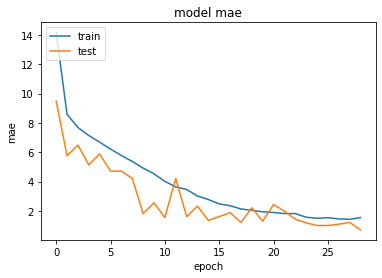

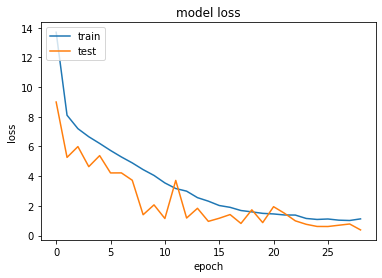

In [14]:
#summarize history for mae 
plt.figure(1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()